# CS 543 Final Project: Grading of Diabetic Retinopathy Severity Level


## Image segmentation

## Hongshuo Wang

In [1]:
# References:
# https://keras.io/examples/vision/oxford_pets_image_segmentation/
# https://idiotdeveloper.com/polyp-segmentation-using-unet-in-tensorflow-2/
# https://github.com/orobix/retina-unet
# https://drive.grand-challenge.org/

In [2]:
from tensorflow.keras import layers
import tensorflow
num_classes = 1
img_size = (512,512)

def get_model(img_size, num_classes):
    inputs = tensorflow.keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 1, activation="sigmoid", padding="same")(x)

    # Define the model
    model = tensorflow.keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
tensorflow.keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Training

In [3]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard


In [4]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image, ImageSequence, ImageOps


def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "1st_manual/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)


def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_RGB2BGR)
    x = cv2.resize(x, img_size)
    x = x/255.0
    return x

def read_mask(path):
    x = Image.open(path)
    x = ImageOps.grayscale(x)
    x = x.resize(img_size)
    x = np.array(x)/255.0
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([img_size[0], img_size[1], 3])
    y.set_shape([img_size[0], img_size[1], 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset


def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

In [5]:
path = "data/dr seg/training/"

(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
print(train_x)
print(valid_x)
print(test_x)

['data/dr seg/training/images\\34_training.tif', 'data/dr seg/training/images\\24_training.tif', 'data/dr seg/training/images\\26_training.tif', 'data/dr seg/training/images\\33_training.tif', 'data/dr seg/training/images\\35_training.tif', 'data/dr seg/training/images\\31_training.tif', 'data/dr seg/training/images\\40_training.tif', 'data/dr seg/training/images\\29_training.tif', 'data/dr seg/training/images\\23_training.tif', 'data/dr seg/training/images\\27_training.tif', 'data/dr seg/training/images\\32_training.tif', 'data/dr seg/training/images\\25_training.tif', 'data/dr seg/training/images\\37_training.tif', 'data/dr seg/training/images\\30_training.tif', 'data/dr seg/training/images\\28_training.tif', 'data/dr seg/training/images\\39_training.tif']
['data/dr seg/training/images\\21_training.tif', 'data/dr seg/training/images\\38_training.tif']
['data/dr seg/training/images\\36_training.tif', 'data/dr seg/training/images\\22_training.tif']


In [6]:
 ## Hyperparameters
batch = 2
lr = 1e-4
epochs = 20

In [7]:
import matplotlib.pyplot as plt

train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

opt = tf.keras.optimizers.Adam(lr)
metrics = ["acc", tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), iou]
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)


Epoch 1/20
8/8 [==============================] - 8s 194ms/step - loss: 0.6066 - acc: 0.7785 - recall: 0.1884 - precision: 0.1755 - iou: 0.0789 - val_loss: 0.5780 - val_acc: 0.8781 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_iou: 0.0718
Epoch 2/20


C:\Users\wangh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


8/8 [==============================] - 1s 90ms/step - loss: 0.3594 - acc: 0.8536 - recall: 0.1729 - precision: 0.3737 - iou: 0.1313 - val_loss: 0.4712 - val_acc: 0.8797 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_iou: 0.0657
Epoch 3/20
8/8 [==============================] - 1s 90ms/step - loss: 0.3279 - acc: 0.8621 - recall: 0.1334 - precision: 0.4012 - iou: 0.1238 - val_loss: 0.3989 - val_acc: 0.8835 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_iou: 0.0628
Epoch 4/20
8/8 [==============================] - 1s 91ms/step - loss: 0.2903 - acc: 0.8663 - recall: 0.1247 - precision: 0.4358 - iou: 0.1237 - val_loss: 0.3427 - val_acc: 0.8836 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_iou: 0.0575
Epoch 5/20
8/8 [==============================] - 1s 91ms/step - loss: 0.2659 - acc: 0.8709 - recall: 0.1519 - precision: 0.5154 - iou: 0.1425 - val_loss: 0.3202 - val_acc: 0.8836 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_iou: 0.0524
Epoch 6

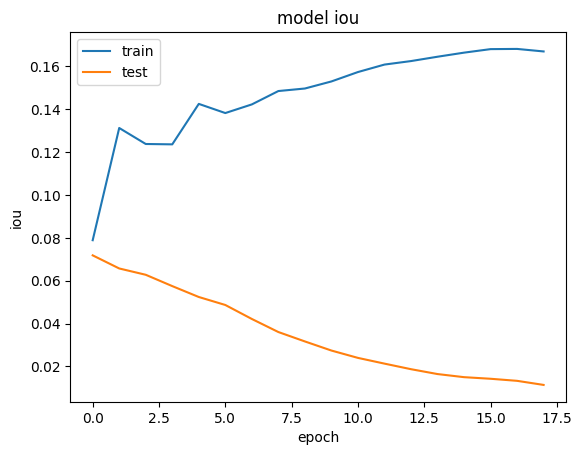

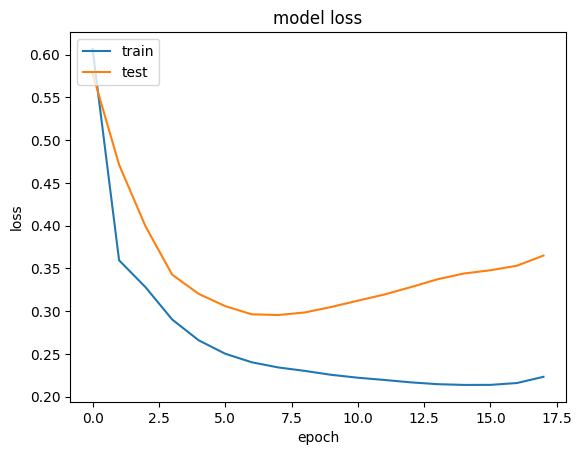

In [8]:
callbacks = [
          ModelCheckpoint("files/model.h5"),
          EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
     ]

train_steps = len(train_x)//batch
valid_steps = len(valid_x)//batch

if len(train_x) % batch != 0:
    train_steps += 1
if len(valid_x) % batch != 0:
    valid_steps += 1

history = model.fit(train_dataset,
            validation_data=valid_dataset,
            epochs=epochs,
            steps_per_epoch=train_steps,
            validation_steps=valid_steps,
            callbacks=callbacks)

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['iou'])
plt.plot(history.history['val_iou'])
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
def read_image_p(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_RGB2BGR)
    x = cv2.resize(x, img_size)
    x = x/255.0
    return x



def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
(512, 512, 1)
(512, 512, 1)


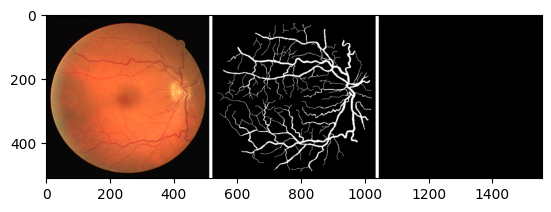

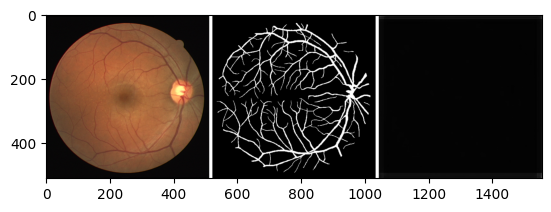

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 50%|██████████████████████████████████████████                                          | 1/2 [00:00<00:00,  1.93it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
(512, 512, 1)
(512, 512, 1)


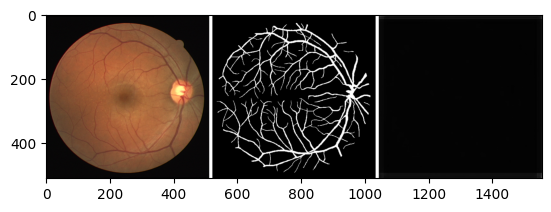

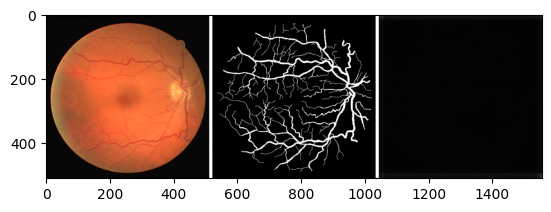

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.93it/s]


In [11]:
import matplotlib.pyplot as plt
for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
    x = read_image_p(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3)) * 255.0
    all_images = [
      x , white_line,
      mask_parse(y), white_line,
      mask_parse(y_pred) 
    ]
    
    image = np.concatenate(all_images, axis=1)
    print(x.shape)
    print(y.shape)
    print(y_pred.shape)
    plt.figure()
    plt.imshow(image) 
    plt.show()
    
    cv2.imwrite(f"files/results/{i}.png", image)
    plt.imshow(image)